In [109]:
import pandas as pd
import geopandas as gpd
import folium
import geopy
from geopy.distance import geodesic
from shapely.geometry import Point
import branca.colormap as cm
from ipywidgets import interact_manual, widgets, VBox, HBox
import ipywidgets as widgets
from sklearn.preprocessing import MinMaxScaler
import zipfile
import os
import fiona
from shapely import wkt
from fuzzywuzzy import process
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [110]:

economia = pd.read_excel('XLS/RAIS_ESTAB_EMPR_COMERCIO_SERVICO_PORTE.xls', sheet_name=-1)

# data_3 = pd.read_csv('RAIS_CSV/GEOINFO_TB_RAIS_2015_Dados.csv', encoding='latin1')
# data_3_dic = pd.read_csv('RAIS_CSV/GEOINFO_TB_RAIS_2015_Variáveis.csv', encoding='latin1')}
estacoes = pd.read_parquet("estacoes_reestruturadas.parquet")

shapefile_path ="./SIRGAS_SHP_distrito/SIRGAS_SHP_distrito.shp"
# Carregar o shapefile
distritos = gpd.read_file(shapefile_path)
distritos = distritos.set_crs("EPSG:31983")
distritos = distritos.to_crs("EPSG:4326")

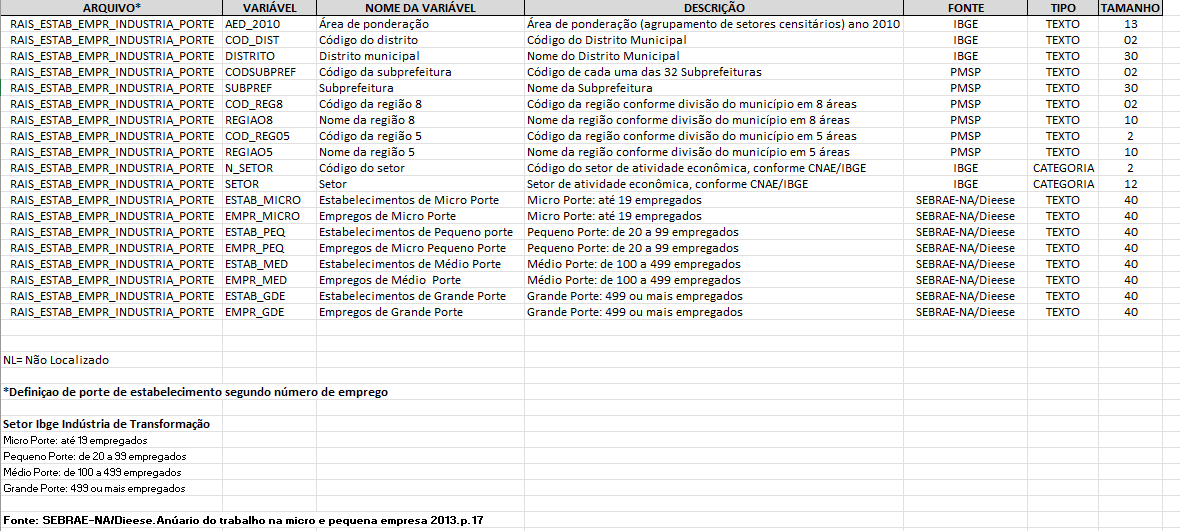

In [111]:
economia['SETOR'].unique()

array(['COMÉRCIO E SERVIÇOS'], dtype=object)

In [112]:
economia.shape

(311, 19)

# Funções de Estações

In [113]:
## Prepara o dataframe de estações para as outras análises
## Retorna o dataframe tratado
def tratar_df_estacoes(df_estacoes):
    ## Cria uma geometria "Point"
    df_estacoes = gpd.GeoDataFrame(df_estacoes, geometry = gpd.points_from_xy(df_estacoes['lon'], df_estacoes['lat']))
    ## Define crs
    df_estacoes.set_crs("EPSG:4326", inplace = True)
    return df_estacoes

## Cria circles (geometry Polygon) em volta de cada estação (geometry Point)
## Retorna o dataframe com a geometria "circles"
def criar_circulos_estacao(data, radius_km):
    circles = []
    for _, row in data.iterrows():
        circle_points = []
        center = (row['lat'], row['lon'])
        ## Dizemos que é aproximadamente um círculo, pois é um polígono regular com 360 vértices
        for angle in range(0,360, 1): 
            destination = geopy.distance.distance(kilometers = radius_km).destination(center, angle)
            circle_points.append(Point(destination.longitude, destination.latitude))
        circle = gpd.GeoSeries(circle_points).unary_union.convex_hull
        circles.append(circle)
    data.rename(columns = {'geometry':'point'}, inplace = True)
    circles_gdf = gpd.GeoDataFrame(data, geometry = circles)
    circles_gdf.rename(columns = {'geometry':'circle'}, inplace = True)
    return circles_gdf

## Adiciona os círculos no mapa, usa como base a função "criar_circulos_estacao"
## Retorna o Mapa com os círculos (geometry polygon) e pontos (geometry point) adicionados
def adicionar_estacoes_com_circulos_mapa(mapa, df_estacoes, radius_km):
    ## Definição dos layers para controle do usuário por camadas
    layer_estacoes =  folium.FeatureGroup(name = "Estações")
    layer_circulos_estacoes = folium.FeatureGroup(name = f"Redondezas {radius_km} km") 
    ## Se o df_estacoes já tem os circles, não precisa criá-los
    if "circle" not in df_estacoes:
        data = criar_circulos_estacao(df_estacoes, radius_km)
    else:
        data = df_estacoes.copy()
    ## Define "circle" como geometria a ser usada, pois há mais de uma em uso
    data.set_geometry("circle", inplace = True)
    ## Adiciona Circlemarkers ao layer
    for _, row in data.iterrows():
        folium.CircleMarker(
                    location=[row['lat'],row['lon']],
                    color = "blue",
                    radius= 5,
                    tooltip= row['name'],
                    fill=True,
                    fill_opacity=1,
                    fill_color="blue",
                ).add_to(layer_estacoes)
    ## Adiciona os Circles ao layer
    for _, row in data.iterrows():
        folium.GeoJson(
            row['circle'].__geo_interface__, 
            tooltip = row['name'],
            style_function=lambda x:{'fillColor': 'gray', 'color': 'gray', 'fillOpacity': 0.0},
        ).add_to(layer_circulos_estacoes)
        layer_estacoes.add_to(mapa)
        layer_circulos_estacoes.add_to(mapa)
        folium.LayerControl().add_to(mapa)
    return mapa

# Funções de Mapa

In [114]:
## Cria um mapa centrado em São Paulo
def criar_mapa_sp():
    mapa_sp = folium.Map(location = [-23.550520, -46.633308], zoom_start = 12)
    return mapa_sp

## Plota Circlemarkers de 1 cor, dado 1 df com Lat e Lon
def plot_circlemarkers_one_color(data, color, radius, name, pontuacao, layer):
    for _, row in data.iterrows():
        folium.CircleMarker(
                location = [row['lat'], row['lon']],
                color = color, 
                radius = radius,
                tooltip = row[name] + " " + str(row[pontuacao]), 
                popup = row[name] + " " + str(row[pontuacao]), 
                fill = True,
                fill_opacity = 1,
                fill_color = color,
        ).add_to(layer)

## Plota Circlemarkers de várias cores, dado 1 df com Lat e Lon e um Colormap branca
def plot_circlemarkers_multi_color(data, radius, name, pontuacao, layer, colormap):
    for _, row in data.iterrows():
        folium.CircleMarker(
                location = [row['lat'], row['lon']],
                color = colormap(row[pontuacao]), 
                radius = radius,
                tooltip = row[name] + " " + str(row[pontuacao]), 
                popup =  row[name] + " " + str(row[pontuacao]), 
                fill = True,
                fill_opacity = 1,
                fill_color = colormap(row[pontuacao]),
        ).add_to(layer)
        
    


## Funções de Outliers

In [164]:
## Plota os Circlemarkers outliers dado um out_lower, out_upper e non_outliers, separados pela função "identificar_outliers"
def plot_circlemarkers_outliers(out_lower, out_upper, non_outliers, color_lower, color_upper, radius, 
                                name, pontuacao, layer, colormap):
    plot_circlemarkers_one_color(out_lower, color_lower, radius, name, pontuacao, layer)
    plot_circlemarkers_one_color(out_upper, color_upper, radius, name, pontuacao, layer)
    plot_circlemarkers_multi_color(non_outliers, radius, name, pontuacao, layer, colormap)

def identificar_outliers(df, coluna):
    """
    Identifica outliers em uma coluna de um DataFrame usando o método IQR.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna (str): Nome da coluna para identificar os outliers.

    Retorna:
        outliers_lower (pd.DataFrame): DataFrame contendo os outliers inferiores.
        outliers_upper (pd.DataFrame): DataFrame contendo os outliers superiores.
        non_outliers (pd.DataFrame): DataFrame contendo os dados não-outliers.
    """
    Q1 = df[coluna].quantile(0.25) 
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    lowerbound = Q1 - 1.5 * IQR
    upperbound = Q3 + 1.5 * IQR

    outliers_lower = df[df[coluna] < lowerbound]
    outliers_upper = df[df[coluna] > upperbound]
    non_outliers = df[(df[coluna] >= lowerbound) & (df[coluna] <= upperbound)]

    return outliers_lower, outliers_upper, non_outliers 


## Função de Economia

In [226]:
def mapa_cores_regioes(df_economia, column_name, criterio):
    # df_economia[column_name] = pd.to_numeric(df_economia[column_name], errors='coerce')
    # df_economia[column_name] = df_economia[column_name].astype(float)
  
    df_economia = df_economia.groupby('distrito').agg({
        column_name: criterio,
        'geometry': 'first' 
    }).reset_index()
    out_lower, out_upper, non_out = identificar_outliers(df_economia, column_name)
    mapa = criar_mapa_sp()
    for data, color, tipo in zip([out_lower, out_upper, non_out], ["Greys", "Blues", "Oranges"], ["Lower", "Upper", "Normal"]):
        if not data.empty:
            data = gpd.GeoDataFrame(data, geometry='geometry')
            geojson_data = data.to_json()
            folium.Choropleth(
                geo_data=geojson_data,
                name="choropleth",
                data=df_economia,
                columns=["distrito", column_name],
                key_on="feature.properties.distrito",
                fill_color=color,
                fill_opacity=0.7,
                line_opacity=0.2,
                legend_name=f"Legenda: {column_name}",
                highlight=True,
                tooltip=folium.Tooltip(
                    f"{column_name}: " + non_out[column_name].astype(str)  
                )
            ).add_to(mapa)
    for _, row in df_economia.iterrows():
        folium.GeoJson(
            row['geometry'],
            tooltip=folium.Tooltip(f"{row['distrito']}: {row[column_name]}"),  # Exibindo o valor da coluna
            style_function=lambda x:{'fillColor': 'gray', 'color': 'gray', 'fillOpacity': 0.0},
        ).add_to(mapa)

    folium.TileLayer('cartodbpositron').add_to(mapa)
    folium.TileLayer('cartodbdark_matter').add_to(mapa)
    folium.TileLayer('stamentoner').add_to(mapa)
    folium.TileLayer('stamenterrain').add_to(mapa)
    	
    folium.TileLayer('stamenwatercolor').add_to(mapa)
    folium.LayerControl().add_to(mapa)
    return mapa

def roda_mapa_cores_regioes(df_economia):
    im = interact_manual(
        lambda column_name, criterio: mapa_cores_regioes(df_economia, column_name, criterio),
        column_name=widgets.Dropdown(options=[col for col in df_economia.columns if col not in ['geometry', 'AEDS_2010'	,'COD_DIST'	,'ds_codigo',
                                                                                                'ds_cd_sub'	,'ds_subpref',	
                                                                                                'ds_sigla',	'ds_areamt',
                                                                                                'ds_areakm','distrito'	,
                                                                                                'CODSUBPREF','SUBPREF'	,'COD_REG8'	,'REGIAO8',	
                                                                                             'COD_REG05'	,'REGIAO5'	,'N_SETOR'	,'SETOR']]),
        criterio=widgets.Dropdown(options=[('Soma', 'sum'), ('Média', 'mean')]),

    )
    im.widget.children[0].description = 'Coluna para Exibição'


In [227]:
df_estacoes = tratar_df_estacoes(estacoes)

In [228]:
distritos.rename(columns = {'ds_nome':'DISTRITO'}, inplace = True)
economia_tratado = pd.merge(economia, distritos, on='DISTRITO', how =  'left')
economia_tratado.rename(columns = {'DISTRITO':'distrito'}, inplace = True)

economia_tratado = economia_tratado.dropna(axis=0)

In [229]:
roda_mapa_cores_regioes(economia_tratado)

interactive(children=(Dropdown(description='column_name', options=('ESTAB_MICRO', 'EMPR_MICRO', 'ESTAB_PEQUENO…